# Activations

We extract hidden layer's activations from models.

In [45]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

import logomaker

from NegativeClassOptimization import ml, visualisations
from NegativeClassOptimization import config, utils
from NegativeClassOptimization import preprocessing

In [10]:
# Load pytorch model with torch
model_path = "../data/Frozen_MiniAbsolut_ML/1_vs_1/3VRL__vs__1NSN/swa_model/data/model.pth"
model = torch.load(model_path, map_location=torch.device('cpu'))

# Load test data
test_data_path = "../data/Frozen_MiniAbsolut_ML/1_vs_1/3VRL__vs__1NSN/7229b1e9_test_dataset.tsv"
df = pd.read_csv(test_data_path, sep="\t")
df

,Slide,binds_a_pos_ag,Slide_onehot,X,y
0,AALITTPLYFD,0,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0
1,AANWDLLFDYW,1,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1
2,AANWELFFDYW,1,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1
3,AAVVAVPMDYW,0,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0
4,ACGLRRGFAYW,0,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0
...,...,...,...,...,...
9995,YYTIHGGFAYW,0,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0
9996,YYTLFYAMDYW,1,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1
9997,YYTLTPGFAYW,0,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0
9998,YYYGSLPMDYW,0,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0


In [22]:
def get_activations_on_slide(slide: str, model: nn.Module):
    x = torch.tensor(preprocessing.onehot_encode(slide)).reshape((1, -1))
    x = x.float()
    x = model.module.flatten(x)
    x = model.module.linear_1(x)
    x = model.module.activation(x)
    return x

def get_logits_on_slide(slide: str, model: nn.Module):
    x = get_activations_on_slide(slide, model)
    x = model.module.linear_2(x)
    return x

def get_linear_2_weights(model: nn.Module):
    return model.module.linear_2.weight


w2 = get_linear_2_weights(model)
print(w2)
x = get_activations_on_slide(df["Slide"].iloc[0], model)
x

Parameter containing:
tensor([[ 2.2674,  2.8184, -3.4706,  2.1558, -2.6300, -3.9646, -1.5313,  1.4877,
          3.1295,  1.6104]], requires_grad=True)


tensor([[2.7953, 1.5519, 0.0000, 3.5858, 0.0000, 0.0000, 0.0000, 3.8775, 0.0000,
         3.8314]], grad_fn=<ReluBackward0>)

In [24]:
records = []
for i, row in df.iterrows():
    slide = row["Slide"]
    
    activations = get_activations_on_slide(slide, model)
    logits = get_logits_on_slide(slide, model)

    record = {
        "Slide": slide,
        "logits": float(logits),
        **{f"neuron_{j}": float(a) for j,a in enumerate(activations.tolist()[0])},
    }
    records.append(record)

df_comp = pd.DataFrame.from_records(records)
df = pd.read_csv(test_data_path, sep="\t")
df = pd.merge(df, df_comp, on="Slide")
df = df.sort_values("logits", ascending=False)
df = df.reset_index(drop=True)
print(df.shape)
# df

(10000, 16)


Text(0.5, 0, 'Slide ~ logit')

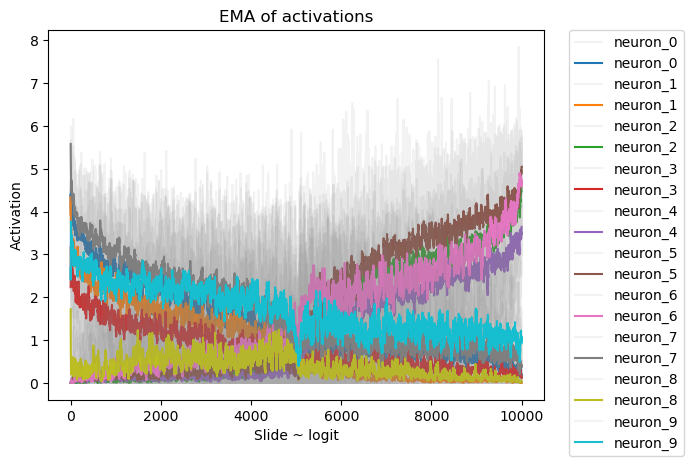

In [26]:
for i in range(10):

    # Compute EMA
    # Plot column without label in legend
    df[f"neuron_{i}"].plot(alpha=0.1, label=None, color="gray")
    ema = df[f"neuron_{i}"].ewm(span=30).mean()
    ema.plot()

# Place legend out of grid
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title("EMA of activations")
plt.ylabel("Activation")
plt.xlabel("Slide ~ logit")

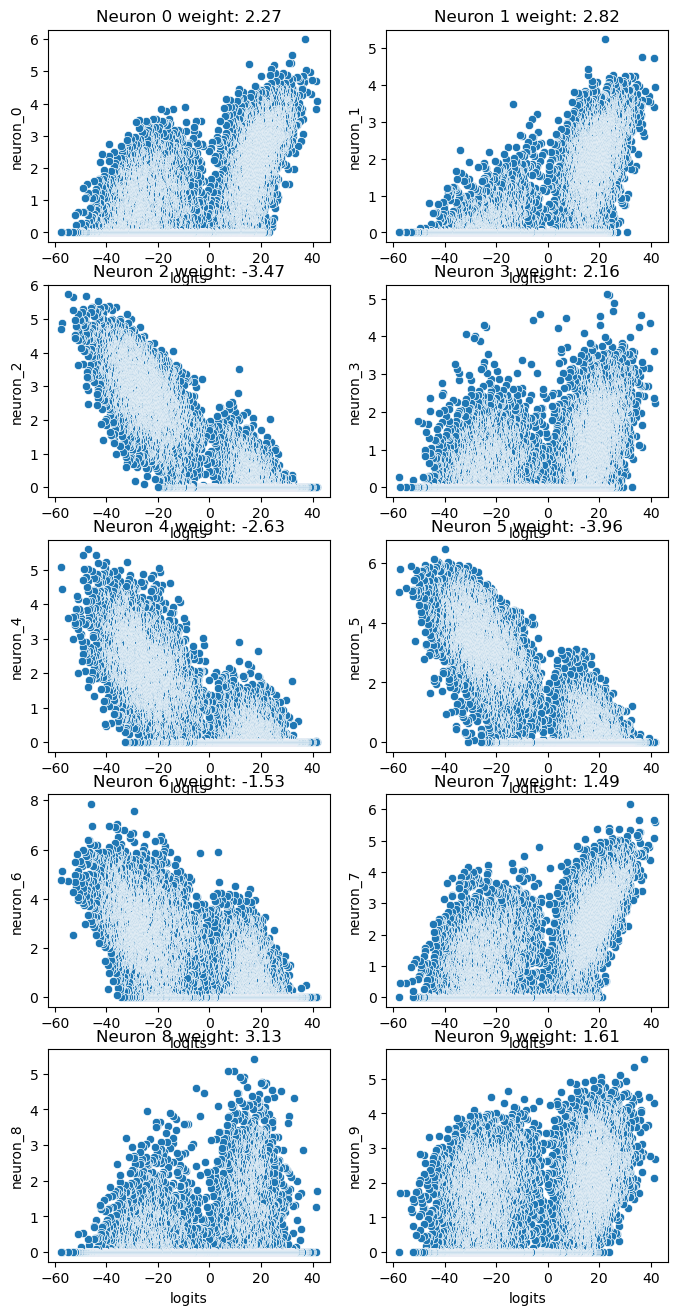

In [31]:
# Plot for each neuron activation vs logits in 
# a seaborn multiplot. Add w2 weights to title.
fig, axes = plt.subplots(5, 2, figsize=(8, 16))
for i, ax in enumerate(axes.flatten()):
    sns.scatterplot(x="logits", y=f"neuron_{i}", data=df, ax=ax)
    ax.set_title(f"Neuron {i} weight: {round(float(w2[0][i]), 2)}")

In [41]:
w1 = model.module.linear_1.weight
pd.DataFrame(w1[0].reshape((11, 20)).detach().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.591855,0.558841,0.002024,-0.318383,0.313095,-0.316947,-0.042755,0.190753,0.215170,-0.199971,0.022792,-0.164724,-0.201295,-1.073322,-0.186445,-0.645986,-0.044371,0.074591,0.109146,0.491503
1,0.335011,-0.541771,-0.598843,-0.464062,0.284534,-0.127263,0.264095,0.467309,-0.793761,-0.402358,0.458376,-0.426264,0.130559,-0.690356,-0.327943,-0.107059,0.322674,0.017927,0.434152,0.085077
2,0.118565,0.078786,0.320376,0.560803,-1.202288,0.274095,0.323407,-1.309232,0.099464,-0.535190,-0.684498,0.148297,0.588325,0.279088,0.538625,0.080444,-0.342082,0.149080,-0.422644,-0.131574
3,-0.843882,0.085989,-0.967606,-0.686082,0.908189,-0.299933,0.453287,0.661768,-0.719061,0.519059,0.380426,-0.636347,-0.740031,-0.229894,-0.927736,-0.645190,-0.756867,0.370854,0.437031,-0.165108
4,-0.291505,0.678454,-0.327322,-0.204882,0.556343,0.330108,-0.065689,1.375006,-0.658742,0.109000,0.674817,-0.053920,0.124179,-0.137790,-0.219654,0.072400,-0.547350,0.650131,-0.147442,-0.408216
5,-0.284988,0.339708,-0.904949,-0.894191,0.370971,-0.525062,-0.438406,0.853406,-0.301210,0.519069,0.022785,-1.124189,-0.820981,-0.618504,-0.596923,-1.440871,-0.410226,0.116235,0.084432,0.263455
6,-0.610647,0.307342,-0.236428,0.168848,0.631820,-0.536344,-0.405382,0.817538,-0.186357,0.650309,0.408626,-0.363416,-0.058794,-0.289369,-0.264410,-0.915185,0.067511,0.557194,0.685805,-0.189673
7,-1.104957,-0.570677,-1.121726,0.308369,0.613479,-0.471776,1.030269,0.331264,-0.194090,0.486090,-0.732945,0.043619,-0.968957,-1.147213,-1.362216,0.296947,-0.556377,0.275309,0.812706,0.520499
8,0.561140,0.735000,-0.617909,0.186653,-0.024736,0.585483,-0.274662,-0.296612,0.327458,-0.083406,0.118433,-0.611479,0.305703,0.154616,-0.392025,-0.075245,0.472431,-0.050004,0.270008,0.249529
9,0.552534,0.234039,-0.548096,-0.030220,-0.106614,0.155573,0.496773,0.078197,0.056505,-0.350055,0.593830,-0.497591,-0.207475,-0.178926,-0.358557,-0.160113,-0.256460,-0.028240,0.171586,0.074134


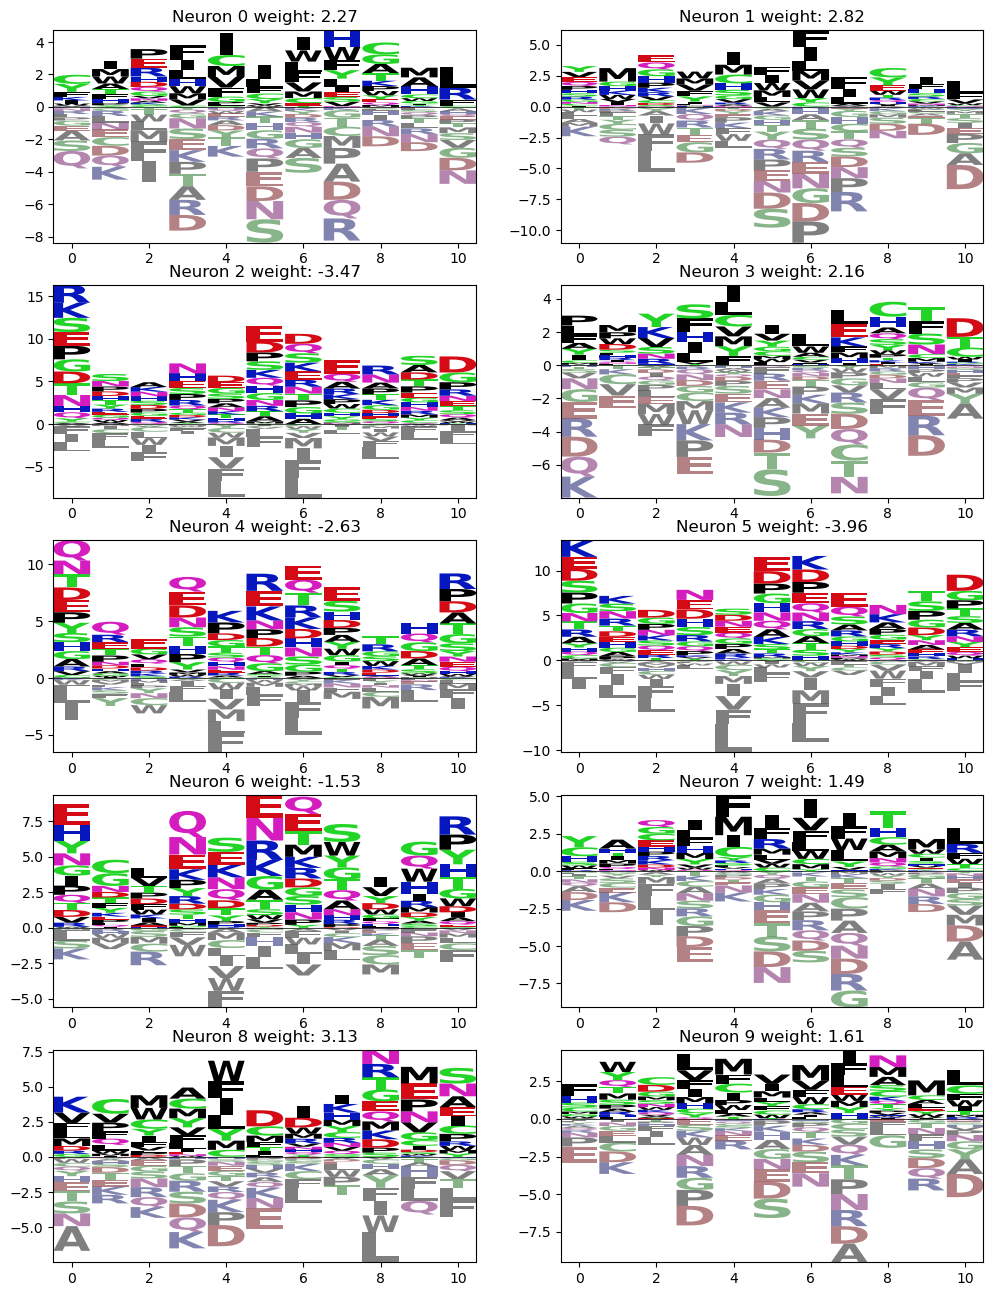

In [47]:
# Plot for each neuron motif logo with logomaker
# based on the weights in w1.
fig, axes = plt.subplots(5, 2, figsize=(12, 16))
for i, ax in enumerate(axes.flatten()):
    w1 = model.module.linear_1.weight
    logo = visualisations.plot_logo(
        pd.DataFrame(w1[i].reshape((11, 20)).detach().numpy(), columns=config.AMINOACID_ALPHABET),
        ax=ax)
    ax.set_title(f"Neuron {i} weight: {round(float(w2[0][i]), 2)}")

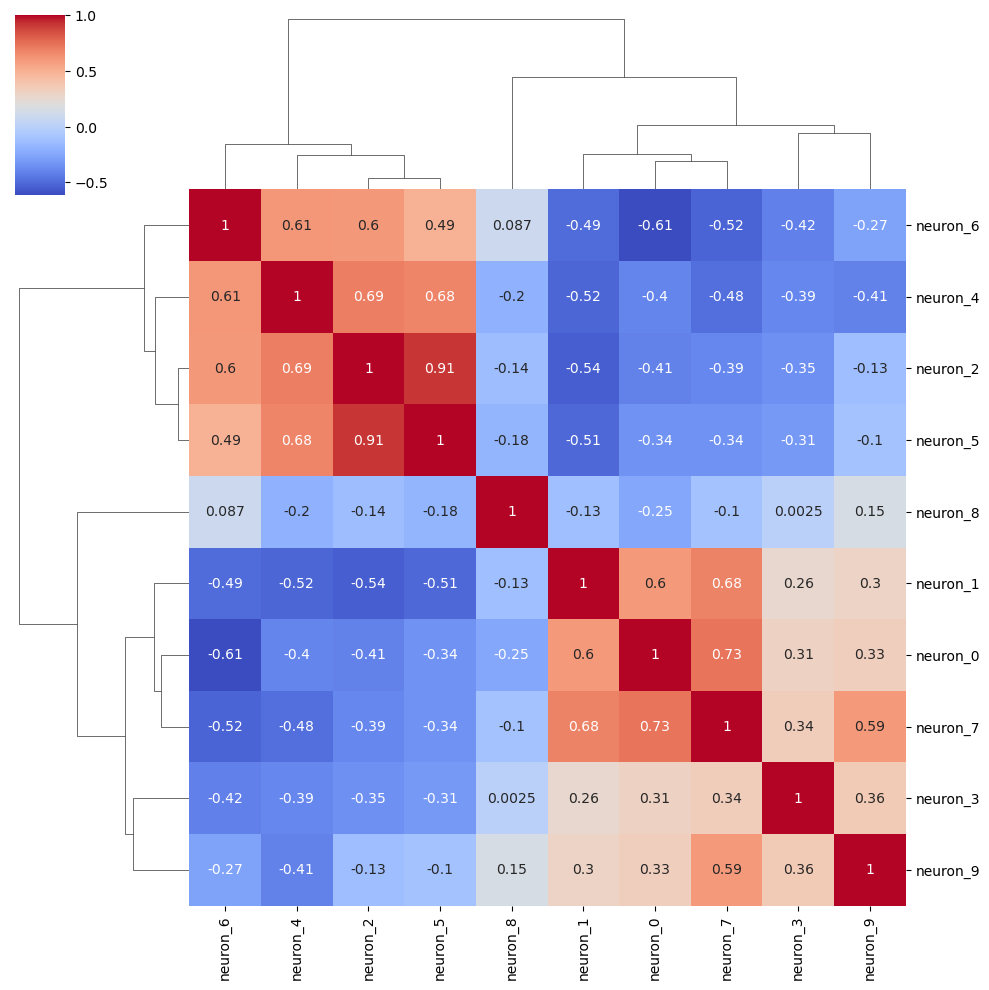

In [49]:
# Correlation among neuron activations
corr = df[[f"neuron_{i}" for i in range(10)]].corr()
sns.clustermap(corr, annot=True, cmap="coolwarm")

In [53]:
# Add info from xstreme and compare
df_x = pd.read_csv(
    "../data/xstreme/1vs1/3VRL_vs_1NSN/xstreme.tsv", 
    sep="\t",
    skipfooter=4,
    )
df_x

/tmp/ipykernel_492830/1713339401.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df_x = pd.read_csv(


,RANK,SEED_MOTIF,CLUSTER,SOURCE,ID,ALT_ID,CONSENSUS,WIDTH,SITES,SEA_PVALUE,EVALUE,EVALUE_ACC,SIM_SOURCE,SIM_MOTIF,MOTIF_URL
0,1,1,1,STREME,1-LLDYF,STREME-1,LLDYF,5,4584,0.000000e+00,1.870000e-121,1,STREME,1-LLDYF,
1,2,1,2,STREME,2-CARG,STREME-2,CARG,4,1727,1.300000e-166,4.700000e-19,1,STREME,2-CARG,
2,3,0,2,STREME,6-CARLIL,STREME-6,CARLIL,6,40,2.330000e-155,1.310000e+00,1,STREME,6-CARLIL,
3,4,0,2,STREME,4-CARLRW,STREME-4,CARLRW,6,63,1.070000e-79,5.350000e-02,1,STREME,4-CARLRW,
4,5,0,2,STREME,5-ARQL,STREME-5,ARQL,4,123,4.990000e-68,2.240000e-01,1,STREME,5-ARQL,
5,6,0,2,STREME,3-ARRW,STREME-3,ARRW,4,130,7.310000e-48,4.180000e-03,1,STREME,3-ARRW,
6,7,0,2,STREME,7-ARBGGW,STREME-7,ARBGGW,6,31,6.310000e-06,3.500000e+00,1,STREME,7-ARBGGW,


In [54]:
df_x = pd.read_csv(
    "../data/xstreme/1vs1/1NSN_vs_3VRL/xstreme.tsv", 
    sep="\t",
    skipfooter=4,
    )
df_x

/tmp/ipykernel_492830/4051951651.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df_x = pd.read_csv(


,RANK,SEED_MOTIF,CLUSTER,SOURCE,ID,ALT_ID,CONSENSUS,WIDTH,SITES,SEA_PVALUE,EVALUE,EVALUE_ACC,SIM_SOURCE,SIM_MOTIF,MOTIF_URL
0,1,1,1,STREME,2-LDYDLDYF,STREME-2,LDYDLDYF,8,997,0.000000e+00,1.790000e-29,1,STREME,2-LDYDLDYF,
1,2,1,2,STREME,1-GGGFAY,STREME-1,GGGFAY,6,2358,0.000000e+00,9.230000e-62,1,STREME,1-GGGFAY,
2,3,1,3,STREME,6-YDYDL,STREME-6,YDYDL,5,176,8.520000e-125,4.960000e-02,1,STREME,6-YDYDL,
3,4,1,4,STREME,8-LRYAWFA,STREME-8,LRYAWFA,7,52,1.720000e-100,1.120000e+00,1,STREME,8-LRYAWFA,
4,5,1,5,STREME,3-LLLRLYWYFD,STREME-3,LLLRLYWYFD,10,341,1.070000e-97,3.420000e-07,1,STREME,3-LLLRLYWYFD,
5,6,1,6,STREME,9-YDGFA,STREME-9,YDGFA,5,49,2.970000e-89,2.810000e+00,1,STREME,9-YDGFA,
6,7,1,7,STREME,7-CARLGGGLAY,STREME-7,CARLGGGLAY,10,60,1.030000e-75,5.590000e-01,1,STREME,7-CARLGGGLAY,
7,8,1,8,STREME,5-RRERLRLFAY,STREME-5,RRERLRLFAY,10,93,9.190000e-52,1.700000e-02,1,STREME,5-RRERLRLFAY,
8,9,1,9,STREME,4-ARVVGLRMDY,STREME-4,ARVVGLRMDY,10,101,1.150000e-33,2.060000e-03,1,STREME,4-ARVVGLRMDY,
